In [1]:
!pip install huggingface_hub


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
!pip install wandb==0.16.0


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
!pip install --upgrade datasets


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [6]:
from datasets import load_dataset
dataset = load_dataset("nateraw/pascal-voc-2012",split = 'train')

In [7]:
# 데이터셋의 기본 정보 출력
print("데이터셋 정보:")
print(dataset)

# 데이터셋의 첫 번째 샘플 출력
print("\n첫 번째 데이터 샘플:")
print(dataset[0])

# 데이터셋의 특정 필드 이름 및 데이터 타입 탐색
print("\n필드 이름 및 데이터 타입:")
for field, field_type in dataset.features.items():
    print(f"{field}: {field_type}")

데이터셋 정보:
Dataset({
    features: ['image', 'mask'],
    num_rows: 1464
})

첫 번째 데이터 샘플:
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x281 at 0x7F08201CB550>, 'mask': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=500x281 at 0x7F08201F0B90>}

필드 이름 및 데이터 타입:
image: Image(decode=True, id=None)
mask: Image(decode=True, id=None)


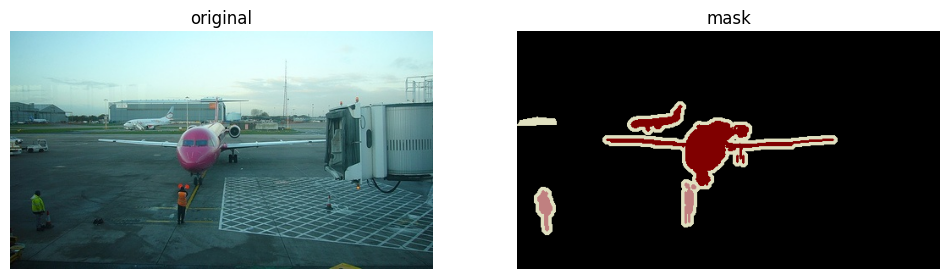

In [8]:
import matplotlib.pyplot as plt

# 첫 번째 데이터 샘플을 로드
first_sample = dataset[0]
image = first_sample['image']
mask = first_sample['mask']

# 이미지와 마스크 표시
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# 원본 이미지
ax[0].imshow(image)
ax[0].set_title('original')
ax[0].axis('off')

# 마스크 이미지
ax[1].imshow(mask)
ax[1].set_title('mask')
ax[1].axis('off')

plt.show()


In [9]:
import os
import math
import numpy as np
import tensorflow as tf
import random
import pickle

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread, imshow,show
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [10]:
# random seed 설정
tf.random.set_seed(42)
random.seed(1234)

In [11]:
image_width, image_height = 224, 224

from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:  # 훈련용 데이터일 경우
        return Compose([
            HorizontalFlip(p=0.5),  # 50%의 확률로 좌우대칭
            Resize(                 # 입력이미지를 224X224로 resize
                width=image_width,
                height=image_height
            )
        ])
    else:  # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다.
        return Compose([
            Resize(
                width=image_width,
                height=image_height
            )
        ])


In [12]:
from PIL import Image
import numpy as np

# 이미지와 마스크를 NumPy 배열로 변환
input_images = np.array(dataset[0]['image'])
input_labels = np.array( dataset[0]['mask'])

# 변환된 배열의 형태 확인
print("Images shape:", input_images.shape)
print("Labels shape:", input_labels.shape)



Images shape: (281, 500, 3)
Labels shape: (281, 500, 3)


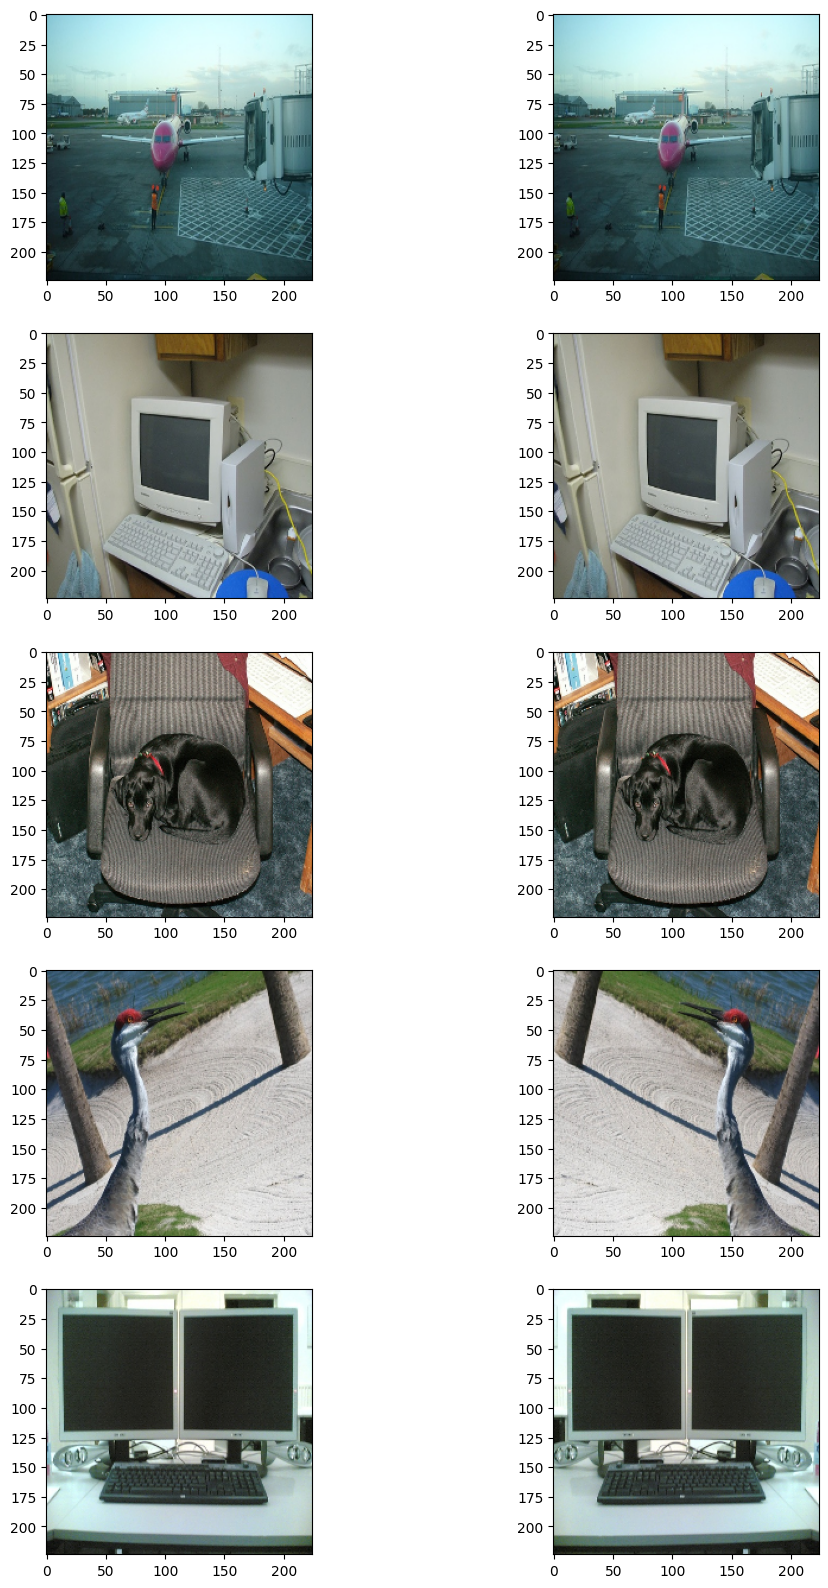

In [13]:
# 데이터 확인
import numpy as np

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image =  np.array(dataset[i]['image'])
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [14]:
input_images = np.array(dataset[0]['image'])
input_labels = np.array( dataset[0]['mask'])

In [15]:
image = input_images
label = input_labels
print(image.shape, label.shape)

(281, 500, 3) (281, 500, 3)


In [16]:
data = {
  "image": image,
  "mask": mask,
  }
image_data = {"image":image,"mask":label}
resized = augmentation_train(**image_data)
# resized_label = augmentation_test(**label_data)
print(resized['image'].shape, resized['mask'].shape)

(224, 224, 3) (224, 224, 3)


In [15]:
# data = {
#   "image": image,
#   "mask": mask,
#   }
# image_data = {"image":image,"mask":label}
# resized = augmentation_test(**image_data)
# # resized_label = augmentation_test(**label_data)
# print(resized['image'].shape, resized['mask'].shape)

In [17]:
import numpy as np
from PIL import Image

def extract_class_color_mapping(masks):
    """
    마스크 이미지들에서 클래스별 색상 매핑을 추출하는 함수
    :param masks: 마스크 이미지의 리스트
    :return: 클래스와 색상의 매핑 딕셔너리
    """
    color_mapping = {}
    class_id = 0

    for mask in masks:
        # 마스크 이미지를 NumPy 배열로 변환
        mask_np = np.array(mask)
        # 고유한 색상 찾기
        unique_colors = np.unique(mask_np.reshape(-1, mask_np.shape[2]), axis=0)

        for color in unique_colors:
            # 색상을 튜플로 변환
            color_tuple = tuple(color)
            # 새로운 색상이면 클래스 ID 할당
            if color_tuple not in color_mapping:
                color_mapping[color_tuple] = class_id
                class_id += 1

    return color_mapping



def map_color_mask_to_integer(color_mask, mapping):
    integer_mask = np.zeros(color_mask.shape[:-1], dtype=np.uint8)
    for row in range(color_mask.shape[0]):
        for col in range(color_mask.shape[1]):
            color = tuple(color_mask[row, col])
            if color in mapping:
                integer_mask[row, col] = mapping[color]
    return integer_mask

### 클래스 컬러 매핑 딕셔너리 만들기 

(없으면 만들어서 저장 ,있으면 불러오기)

In [18]:
# 데이터셋에서 마스크 목록 추출
masks = [sample['mask'] for sample in dataset]
pickle_file = 'class_color_mapping.pkl'
if not os.path.exists(pickle_file):
    # masks 변수는 이미 정의되어 있어야 합니다.
    class_color_mapping = extract_class_color_mapping(masks)

    # 추출한 매핑을 pickle 파일로 저장
    with open(pickle_file, 'wb') as file:
        pickle.dump(class_color_mapping, file)
else:
    # 파일이 이미 존재하는 경우, pickle 파일에서 데이터 불러오기
    with open(pickle_file, 'rb') as file:
        class_color_mapping = pickle.load(file)
print(class_color_mapping)

{(0, 0, 0): 0, (128, 0, 0): 1, (192, 128, 128): 2, (224, 224, 192): 3, (0, 64, 128): 4, (64, 0, 128): 5, (192, 0, 0): 6, (128, 128, 0): 7, (128, 0, 128): 8, (0, 0, 128): 9, (192, 128, 0): 10, (128, 192, 0): 11, (64, 128, 128): 12, (192, 0, 128): 13, (64, 128, 0): 14, (0, 128, 0): 15, (128, 128, 128): 16, (64, 0, 0): 17, (0, 192, 0): 18, (0, 128, 128): 19, (0, 64, 0): 20, (128, 64, 0): 21}


In [19]:
def create_inverse_mapping(class_color_mapping):
    """
    클래스 ID에서 색상으로의 역 매핑을 생성하는 함수
    :param class_color_mapping: 클래스와 색상의 매핑 딕셔너리
    :return: 역 매핑 딕셔너리
    """
    inverse_mapping = {class_id: color for color, class_id in class_color_mapping.items()}
    return inverse_mapping

In [20]:
pickle_file_inverse_mapping = 'inverse_mapping.pkl'
if not os.path.exists(pickle_file_inverse_mapping):

    inverse_mapping = create_inverse_mapping(class_color_mapping)
    # 추출한 매핑을 pickle 파일로 저장
    with open(pickle_file_inverse_mapping, 'wb') as file:
        pickle.dump(inverse_mapping, file)
else:
    # 파일이 이미 존재하는 경우, pickle 파일에서 데이터 불러오기
    with open(pickle_file_inverse_mapping, 'rb') as file:
        inverse_mapping = pickle.load(file)
print(inverse_mapping)

{0: (0, 0, 0), 1: (128, 0, 0), 2: (192, 128, 128), 3: (224, 224, 192), 4: (0, 64, 128), 5: (64, 0, 128), 6: (192, 0, 0), 7: (128, 128, 0), 8: (128, 0, 128), 9: (0, 0, 128), 10: (192, 128, 0), 11: (128, 192, 0), 12: (64, 128, 128), 13: (192, 0, 128), 14: (64, 128, 0), 15: (0, 128, 0), 16: (128, 128, 128), 17: (64, 0, 0), 18: (0, 192, 0), 19: (0, 128, 128), 20: (0, 64, 0), 21: (128, 64, 0)}


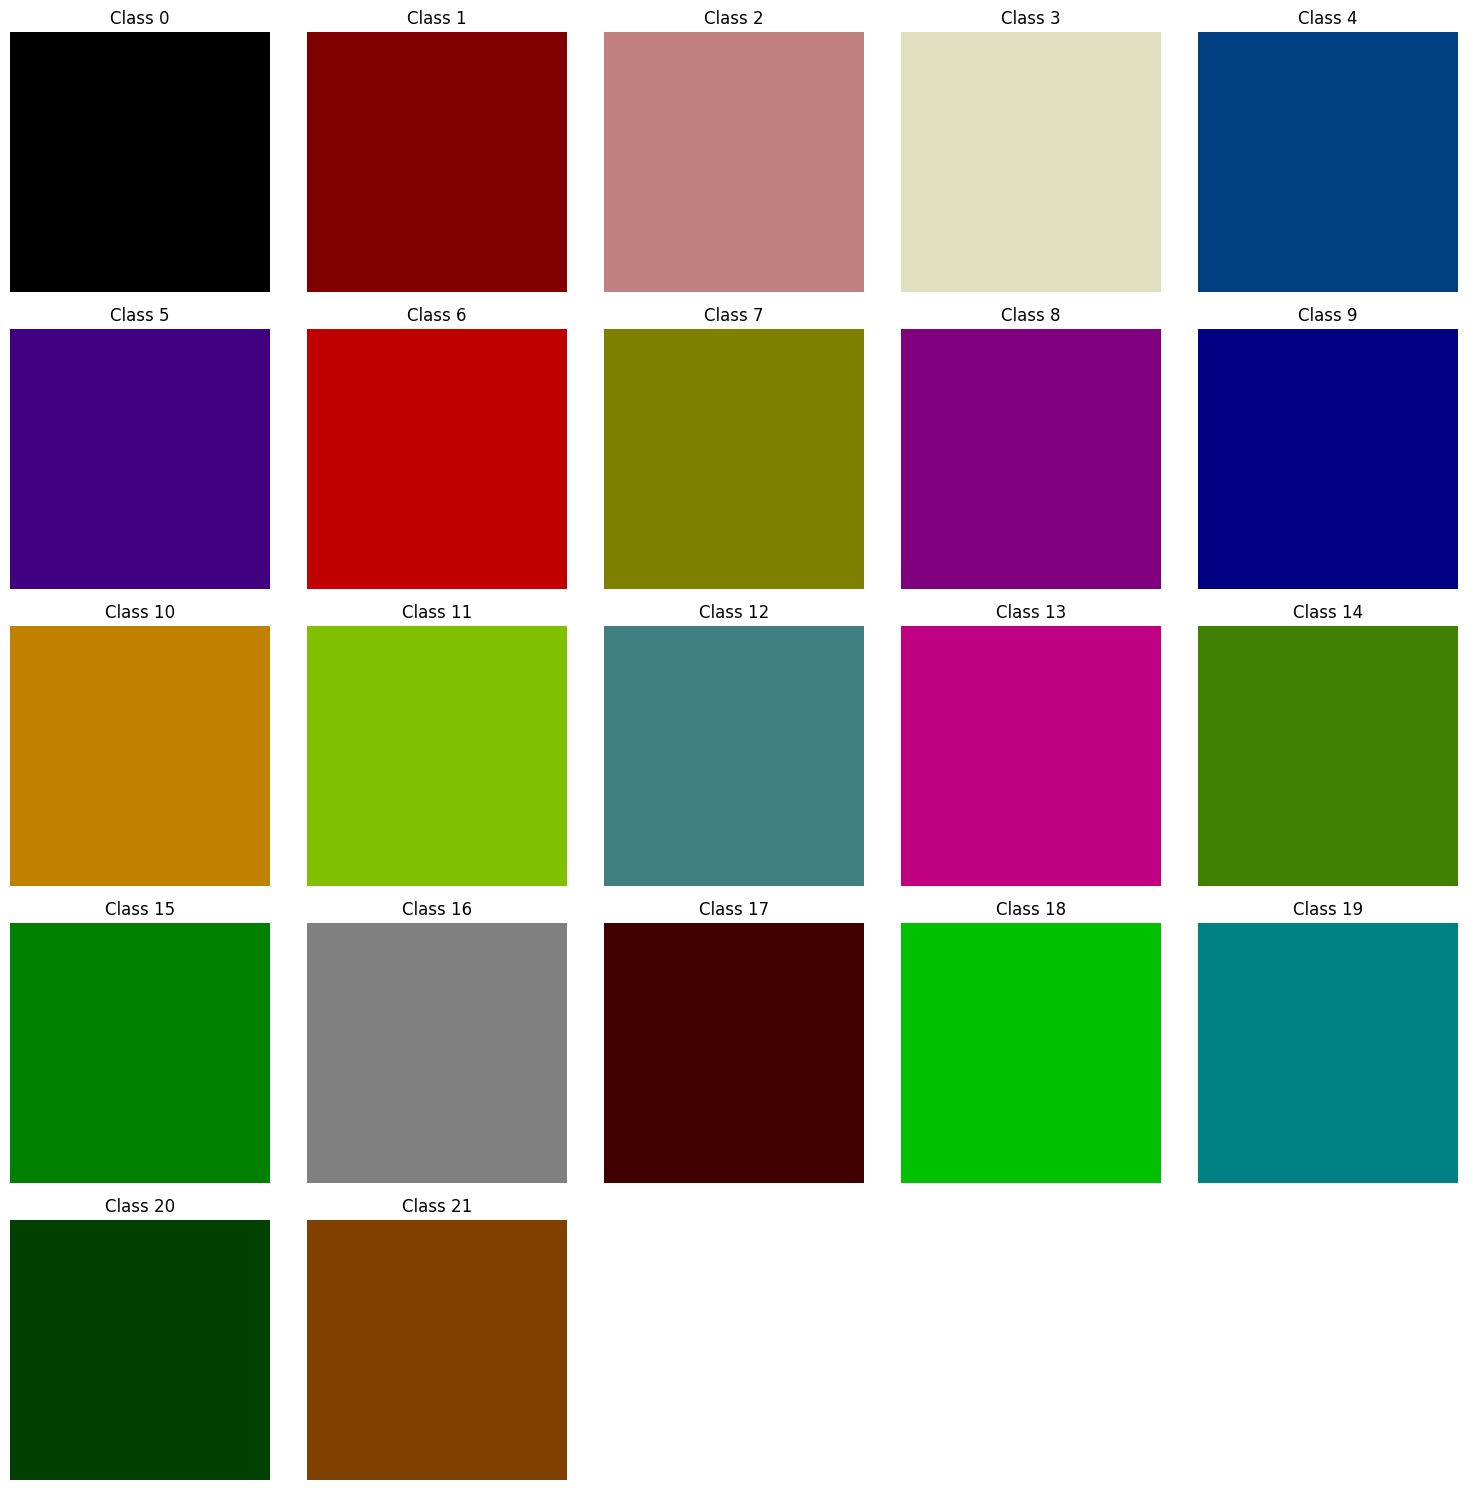

In [21]:
# 5행 5열의 서브플롯 생성
plt.figure(figsize=(15, 15))
for class_id, color in inverse_mapping.items():
    ax = plt.subplot(5, 5, class_id + 1)
    ax.set_title(f"Class {class_id}")
    ax.imshow(np.full((10, 10, 3), color, dtype=np.uint8))  # 색상으로 채운 작은 이미지 생성
    ax.axis('off')

# 나머지 빈 서브플롯 숨기기
for i in range(len(inverse_mapping) + 1, 26):
    ax = plt.subplot(5, 5, i)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [22]:
np.array(resized['mask']).shape

(224, 224, 3)

In [23]:
# 컬러 시맨틱 세그멘테이션 마스크를 정수로 변환
integer_mask = map_color_mask_to_integer(np.array(resized['mask']), class_color_mapping)
integer_mask.shape

(224, 224)

In [24]:
def map_integer_mask_to_color(integer_mask, reverse_mapping):
    color_mask = np.zeros((integer_mask.shape[0], integer_mask.shape[1], 3), dtype=np.uint8)
    for row in range(integer_mask.shape[0]):
        for col in range(integer_mask.shape[1]):
            class_idx = integer_mask[row, col]
            color = reverse_mapping[class_idx]
            # 컬러 값을 [0, 255] 범위로 스케일링
            scaled_color = np.clip(color, 0, 255)
            color_mask[row, col] = scaled_color

    return color_mask

restored_color_mask = map_integer_mask_to_color(integer_mask, inverse_mapping)

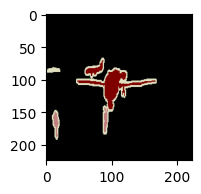

In [25]:
plt.subplot(1, 3, 2)
plt.imshow(restored_color_mask)

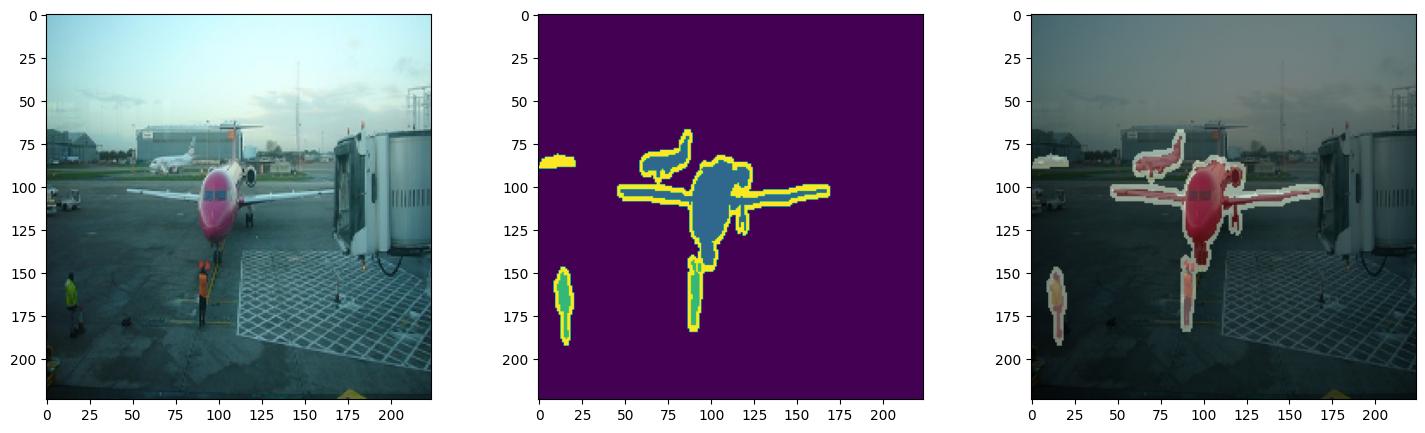

In [26]:
plt.figure(figsize = (18,5))
plt.subplot(1, 3, 1)
plt.imshow(resized["image"])
plt.subplot(1, 3, 2)
plt.imshow(integer_mask)
plt.subplot(1, 3, 3)
plt.imshow(Image.blend(Image.fromarray(resized["image"]),Image.fromarray(restored_color_mask), alpha=0.5))
plt.show()

In [27]:
import os
import math
import random
import numpy as np
from glob import glob
from skimage.io import imread
from PIL import Image
from datasets import DatasetDict
from io import BytesIO
from tensorflow.keras.utils import to_categorical
class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self , batch_size=16, img_size=(224, 224, 3), output_size=(224, 224),
                 is_train=True, is_val=False, augmentation=None):
        '''
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.batch_size = batch_size
        self.is_train = is_train
        self.is_val = is_val
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        self.data = self.load_dataset().to_list()

    def load_dataset(self):
        dataset = load_dataset("nateraw/pascal-voc-2012", split='train')
        shuffled_dataset = dataset.shuffle(seed=42)

        # 데이터셋 분할 비율 설정
        train_ratio = 0.7
        val_ratio = 0.2
        test_ratio = 0.1

        # 훈련, 검증, 테스트 세트로 분할
        split_datasets = shuffled_dataset.train_test_split(test_size=(val_ratio + test_ratio))
        test_dataset = split_datasets['test'].train_test_split(test_size=test_ratio / (val_ratio + test_ratio))

        # 최종적으로 분할된 데이터셋
        data = DatasetDict({
            'train': split_datasets['train'],
            'validation': test_dataset['train'],
            'test': test_dataset['test']
        })

        if self.is_train:
            return data['train']
        elif self.is_val:
            return data['validation']
        else:
            return data['test']
    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 인덱스에 맞는 데이터 배치를 가져옵니다.
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_data = self.data[start:end]

        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size[:2]])
        for i, data in enumerate(batch_data):
            img, mask = data["image"]["bytes"], data["mask"]["bytes"]
            image = Image.open(BytesIO(img))
            mask = Image.open(BytesIO(mask))
            _input = np.array(image)
            _output = np.array(mask)
            dataset = {'image': _input, 'mask': _output}
            augmented = self.augmentation(**dataset) if self.augmentation else dataset

            integer_mask = map_color_mask_to_integer(augmented['mask'], class_color_mapping)
            # unique_values, counts = np.unique(integer_mask, return_counts=True)

            # 고유한 값들의 개수 출력
            # num_unique_values = len(unique_values)
            # print(unique_values)
            # print("Number of unique values:", num_unique_values)
            # _output = to_categorical(integer_mask, num_classes=22)
            # outputs[i] = _output 
            outputs[i] = integer_mask 
            image_array = augmented["image"] / 255.0
            inputs[i] = image_array

        return inputs, outputs



    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.is_train:
            np.random.shuffle(self.indexes)
        return self.indexes


In [28]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = DataGenerator(
    augmentation=augmentation,
)
val_generator = DataGenerator(
    augmentation=test_preproc,
    is_train = False,
    is_val = True
)
test_generator = DataGenerator(
    augmentation=test_preproc,
    is_train = False,
    is_val = False
)

In [29]:
train_generator.batch_size,val_generator.batch_size,test_generator.batch_size

(16, 16, 16)

In [30]:
len(train_generator),len(val_generator),len(test_generator) # *16 해야 데이터 수 근사

(64, 19, 10)

In [31]:
for image, mask in train_generator:
        sample_image, sample_mask = image, mask
        break
sample_image.shape, sample_mask.shape

((16, 224, 224, 3), (16, 224, 224))

In [34]:

import matplotlib.pyplot as plt
import tensorflow as tf

def display(display_list, titles=[], display_string=None):
    ''' displays list of images/masks'''
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
        if display_string and i == 1:
            plt.xlabel(display_string, fontsize=12)
        img_arr = display_list[i]
        if i == 0:  # If it's the image
            plt.imshow(tf.keras.preprocessing.image.array_to_img(img_arr))
        else:  # If it's the mask
            plt.imshow(img_arr)
            unique_values, counts = np.unique(img_arr, return_counts=True)
            print(unique_values)
            restored_color_mask2 = map_integer_mask_to_color(img_arr, inverse_mapping)
            plt.imshow(restored_color_mask2)
            
            
    
    plt.show()

def show_image_from_dataset(dataset, n_show=2):
    for i in range(n_show):
        for image, mask in dataset:
            sample_image, sample_mask = image, mask
            break
        display([sample_image[i], sample_mask[i]], titles=['Image', 'True Mask'])


>>>>>> Train Image
[ 0.  3. 11.]


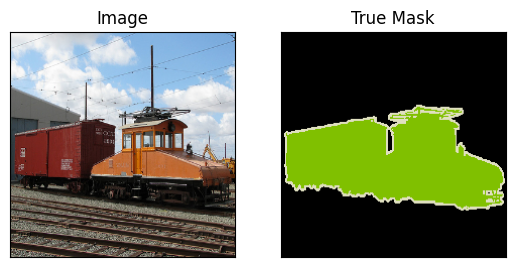

[ 0.  2.  3. 15.]


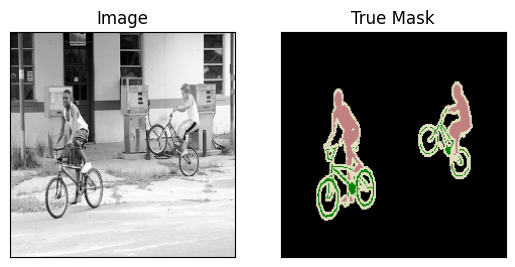

>>>>>> Test Image
[0. 3. 4.]


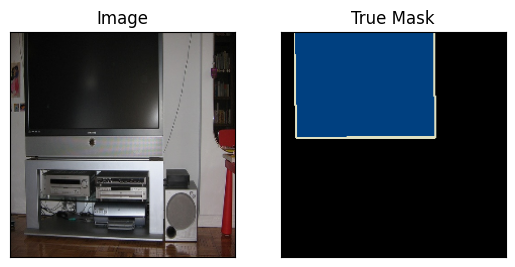

[ 0.  3. 12.]


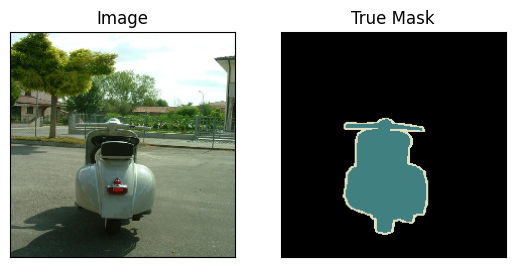

In [35]:
# display an image from the train set

print('>>>>>> Train Image')
show_image_from_dataset(train_generator)
# display an image from the test set
print('>>>>>> Test Image')
show_image_from_dataset(test_generator)

In [36]:
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [37]:
import tensorflow as tf
from tensorflow import keras


import matplotlib.pyplot as plt




from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import utils

In [38]:
def conv_block(filters, x):
    x = Conv2D(filters, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)  # x = Dropout(0.5)(x)
    x = Conv2D(filters, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)  # x = Dropout(0.5)(x)
    return x
def encoder(filters, x) :
    x = conv_block(filters, x)
    pool = MaxPooling2D(pool_size =(2,2))(x)
    return x, pool
def decoder(filters, x, concat):
    x = Conv2DTranspose(filters, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(x)
    x = concatenate([concat, x], axis=3)
    x = conv_block(filters, x)
    return x
def get_outputs(x):
    x = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x)     
    x = Conv2D(22, 1, activation='softmax')(x)
    return x

In [39]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

In [40]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, UpSampling2D, concatenate, Conv2D, BatchNormalization, Activation, Conv2DTranspose
from tensorflow.keras.models import Model
def build_unet_with_backbone(input_shape=(224, 224, 3), num_classes=22):
    inputs = Input(input_shape)

    # 백본 모델 사용 (ResNet50 예시)
    backbone = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    # 인코더 레이어 선택
    layer_names = ["conv1_relu", "conv2_block3_out", "conv3_block4_out", "conv4_block6_out"]
    encoder_outputs = [backbone.get_layer(name).output for name in layer_names]

    # 브릿지
    bridge = backbone.output

    # 디코더 시작
    x = bridge
    for i, f in enumerate([512, 256, 128, 64, 32]):  # 32 필터 추가
        x = Conv2DTranspose(f, (3, 3), strides=(2, 2), padding="same")(x)
        if i < len(encoder_outputs):
            skip_output = encoder_outputs[-(i + 1)]
            x = tf.image.resize(x, skip_output.shape[1:3])
            x = concatenate([x, skip_output])  # Skip connection
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    # 최종 레이어
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(x)

    # 모델 구성
    model = Model(inputs=inputs, outputs=outputs)
    return model

# 모델 생성


In [41]:
unet = build_unet_with_backbone()
unet.summary()

2024-01-11 03:20:24.193254: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 03:20:24.200707: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 03:20:24.204219: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [176]:
EPOCHS=10
MODEL_PATH = './UNET3.keras'

In [177]:
callbacks = keras.callbacks.ModelCheckpoint(
    filepath = MODEL_PATH,
    save_best_only = True,
    save_weights_only = False,
    monitor = 'val_accuracy',
    mode = 'max',
    verbose = 1
)

In [179]:
unet.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [180]:
batch_size = 16
unet_history = unet.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator) ,
    epochs=EPOCHS,
    callbacks = [callbacks]
)

Epoch 1/10
64/64 [==============================] - ETA: 0s - loss: 1.9544 - accuracy: 0.6048
Epoch 1: val_accuracy improved from -inf to 0.64103, saving model to ./UNET3.keras
64/64 [==============================] - 87s 874ms/step - loss: 1.9544 - accuracy: 0.6048 - val_loss: 1.8284 - val_accuracy: 0.6410
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 1.3382 - accuracy: 0.6976
Epoch 2: val_accuracy improved from 0.64103 to 0.70259, saving model to ./UNET3.keras
64/64 [==============================] - 56s 879ms/step - loss: 1.3382 - accuracy: 0.6976 - val_loss: 1.8740 - val_accuracy: 0.7026
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 1.1577 - accuracy: 0.7169
Epoch 3: val_accuracy did not improve from 0.70259
64/64 [==============================] - 54s 844ms/step - loss: 1.1577 - accuracy: 0.7169 - val_loss: 1.9863 - val_accuracy: 0.7026
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 1.0654 - accuracy: 0.7270
Epoch 4:

In [154]:
print('asd')

asd


In [ ]:
import json

# 훈련 기록을 JSON으로 변환
history_dict = unet_history.history
history_dict2 = {"epoch": list(range(len(history_dict["loss"]))) , **history_dict}
history_json = json.dumps(history_dict2, indent=4)

# JSON 파일로 저장
with open("unet_history.json", "w") as json_file:
    json_file.write(history_json)


In [ ]:
with open("unet_history.json", "r") as json_file:
    history_json = json.load(json_file)

In [ ]:
!pip install --upgrade aiffel7

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 2.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 3.0.2
    Uninstalling keras-3.0.2:
      Successfully uninstalled keras-3.0.2
  Attempting uninstall: aiffel7
    Found existing installation: aiffel7 0.5.4
    Uninstalling aiffel7-0.5.4:
      Successfully uninstalled aiffel7-0.5.4

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


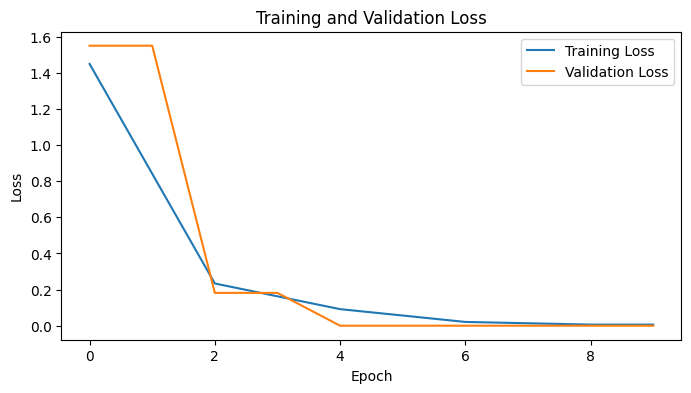

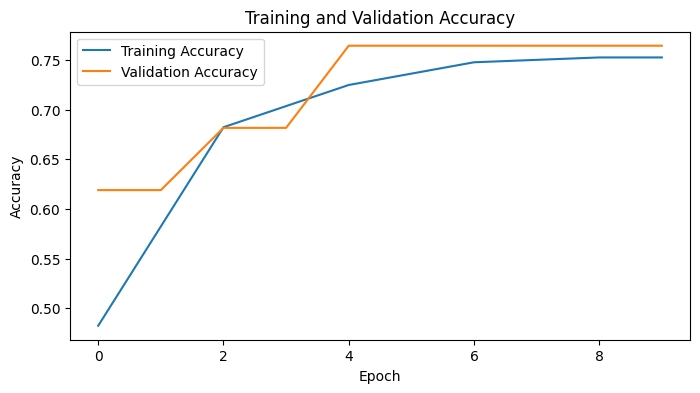

In [ ]:
from aiffel7.historylogger import history_graph

history_graph(history_json)

In [ ]:
def interpolate_zeros(data):
    non_zero_indices = [i for i, x in enumerate(data) if x != 0]

    for idx in range(1, len(non_zero_indices)):
        start_idx = non_zero_indices[idx - 1]
        end_idx = non_zero_indices[idx]
        start_val = data[start_idx]
        end_val = data[end_idx]

        # 선형 보간 계산
        step = (end_val - start_val) / (end_idx - start_idx)
        for i in range(start_idx + 1, end_idx):
            data[i] = data[i - 1] + step

    return data

# 예시 데이터
accuracy = [
    0.48242732882499695, 0.0, 0.6823974251747131, 0.0, 0.7249486446380615, 
    0.0, 0.7478182911872864, 0.0, 0.7526979446411133, 0.0
]
loss = [
    1.4485805034637451, 0.0, 0.23375673592090607, 0.0, 0.09181303530931473, 
    0.0, 0.02106345258653164, 0.0, 0.006313947960734367, 0.0
]

# 보간 처리
accuracy_interpolated = interpolate_zeros(accuracy)
loss_interpolated = interpolate_zeros(loss)

print("Interpolated Accuracy:", accuracy_interpolated)
print("Interpolated Loss:", loss_interpolated)

Interpolated Accuracy: [0.48242732882499695, 0.582412376999855, 0.6823974251747131, 0.7036730349063873, 0.7249486446380615, 0.736383467912674, 0.7478182911872864, 0.7502581179141998, 0.7526979446411133, 0.0]
Interpolated Loss: [1.4485805034637451, 0.8411686196923256, 0.23375673592090607, 0.1627848856151104, 0.09181303530931473, 0.05643824394792318, 0.02106345258653164, 0.013688700273633003, 0.006313947960734367, 0.0]


In [ ]:
unet

In [ ]:
np.array( dataset[0]["image"])

array([[[131, 193, 208],
        [131, 193, 208],
        [131, 193, 208],
        ...,
        [182, 232, 241],
        [182, 232, 241],
        [182, 232, 241]],

       [[132, 194, 209],
        [132, 194, 209],
        [133, 195, 210],
        ...,
        [183, 233, 242],
        [183, 233, 242],
        [182, 232, 241]],

       [[133, 195, 210],
        [133, 195, 210],
        [134, 196, 211],
        ...,
        [183, 233, 242],
        [183, 233, 242],
        [182, 232, 241]],

       ...,

       [[  6,  15,  14],
        [  5,  14,  13],
        [  7,  13,  13],
        ...,
        [ 16,  34,  38],
        [ 16,  34,  38],
        [ 16,  34,  38]],

       [[  5,  14,  13],
        [  9,  18,  17],
        [ 12,  17,  20],
        ...,
        [ 16,  34,  38],
        [ 17,  35,  39],
        [ 17,  35,  39]],

       [[  5,  15,  14],
        [  6,  16,  15],
        [ 10,  18,  20],
        ...,
        [ 16,  33,  40],
        [ 12,  29,  36],
        [ 17,  34,  41]]

In [43]:
from tensorflow.keras.models import load_model

DATA_PATH =  '.'
MODEL_PATH = DATA_PATH +'/UNET2.keras'
# 모델 파일 경로
model_path = MODEL_PATH

# 모델 로드
model = load_model(model_path)

TypeError: Could not deserialize class 'Functional' because its parent module keras.src.models.functional cannot be imported. Full object config: {'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'functional_11', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 224, 224, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_5'}, 'registered_name': None, 'name': 'input_layer_5', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_100', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 3]}, 'name': 'conv2d_100', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 224, 224, 3], 'dtype': 'float32', 'keras_history': ['input_layer_5', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_90', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 64]}, 'name': 'batch_normalization_90', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 224, 224, 64], 'dtype': 'float32', 'keras_history': ['conv2d_100', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_101', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 64]}, 'name': 'conv2d_101', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 224, 224, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_90', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_91', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 64]}, 'name': 'batch_normalization_91', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 224, 224, 64], 'dtype': 'float32', 'keras_history': ['conv2d_101', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_20', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 64]}, 'name': 'max_pooling2d_20', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 224, 224, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_91', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_102', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 64]}, 'name': 'conv2d_102', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 64], 'dtype': 'float32', 'keras_history': ['max_pooling2d_20', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_92', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 128]}, 'name': 'batch_normalization_92', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 128], 'dtype': 'float32', 'keras_history': ['conv2d_102', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_103', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 128]}, 'name': 'conv2d_103', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_92', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_93', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 128]}, 'name': 'batch_normalization_93', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 128], 'dtype': 'float32', 'keras_history': ['conv2d_103', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_21', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 128]}, 'name': 'max_pooling2d_21', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_93', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_104', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 128]}, 'name': 'conv2d_104', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 128], 'dtype': 'float32', 'keras_history': ['max_pooling2d_21', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_94', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'batch_normalization_94', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 256], 'dtype': 'float32', 'keras_history': ['conv2d_104', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_105', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'conv2d_105', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_94', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_95', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'batch_normalization_95', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 256], 'dtype': 'float32', 'keras_history': ['conv2d_105', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_22', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'max_pooling2d_22', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_95', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_106', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 256]}, 'name': 'conv2d_106', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 256], 'dtype': 'float32', 'keras_history': ['max_pooling2d_22', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_96', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'batch_normalization_96', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 512], 'dtype': 'float32', 'keras_history': ['conv2d_106', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_107', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv2d_107', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 512], 'dtype': 'float32', 'keras_history': ['batch_normalization_96', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_97', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'batch_normalization_97', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 512], 'dtype': 'float32', 'keras_history': ['conv2d_107', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_23', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'max_pooling2d_23', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 512], 'dtype': 'float32', 'keras_history': ['batch_normalization_97', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_108', 'trainable': True, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}, 'name': 'conv2d_108', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 512], 'dtype': 'float32', 'keras_history': ['max_pooling2d_23', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_98', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'batch_normalization_98', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 1024], 'dtype': 'float32', 'keras_history': ['conv2d_108', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_109', 'trainable': True, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv2d_109', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 1024], 'dtype': 'float32', 'keras_history': ['batch_normalization_98', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_99', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'batch_normalization_99', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 1024], 'dtype': 'float32', 'keras_history': ['conv2d_109', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_20', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv2d_transpose_20', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 1024], 'dtype': 'float32', 'keras_history': ['batch_normalization_99', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_20', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 28, 28, 512], [None, 28, 28, 512]]}, 'name': 'concatenate_20', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 512], 'dtype': 'float32', 'keras_history': ['batch_normalization_97', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 512], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_20', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_110', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 1024]}, 'name': 'conv2d_110', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 1024], 'dtype': 'float32', 'keras_history': ['concatenate_20', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_100', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'batch_normalization_100', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 512], 'dtype': 'float32', 'keras_history': ['conv2d_110', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_111', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv2d_111', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 512], 'dtype': 'float32', 'keras_history': ['batch_normalization_100', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_101', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'batch_normalization_101', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 512], 'dtype': 'float32', 'keras_history': ['conv2d_111', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_21', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv2d_transpose_21', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 512], 'dtype': 'float32', 'keras_history': ['batch_normalization_101', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_21', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 56, 56, 256], [None, 56, 56, 256]]}, 'name': 'concatenate_21', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_95', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 256], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_21', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_112', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 512]}, 'name': 'conv2d_112', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 512], 'dtype': 'float32', 'keras_history': ['concatenate_21', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_102', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'batch_normalization_102', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 256], 'dtype': 'float32', 'keras_history': ['conv2d_112', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_113', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'conv2d_113', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_102', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_103', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'batch_normalization_103', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 256], 'dtype': 'float32', 'keras_history': ['conv2d_113', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_22', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'conv2d_transpose_22', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_103', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_22', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 112, 112, 128], [None, 112, 112, 128]]}, 'name': 'concatenate_22', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_93', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 128], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_22', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_114', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 256]}, 'name': 'conv2d_114', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 256], 'dtype': 'float32', 'keras_history': ['concatenate_22', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_104', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 128]}, 'name': 'batch_normalization_104', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 128], 'dtype': 'float32', 'keras_history': ['conv2d_114', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_115', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 128]}, 'name': 'conv2d_115', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_104', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_105', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 128]}, 'name': 'batch_normalization_105', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 128], 'dtype': 'float32', 'keras_history': ['conv2d_115', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_23', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 128]}, 'name': 'conv2d_transpose_23', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_105', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_23', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 224, 224, 64], [None, 224, 224, 64]]}, 'name': 'concatenate_23', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 224, 224, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_91', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 224, 224, 64], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_23', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_116', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 128]}, 'name': 'conv2d_116', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 224, 224, 128], 'dtype': 'float32', 'keras_history': ['concatenate_23', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_106', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 64]}, 'name': 'batch_normalization_106', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 224, 224, 64], 'dtype': 'float32', 'keras_history': ['conv2d_116', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_117', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 64]}, 'name': 'conv2d_117', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 224, 224, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_106', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_107', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 64]}, 'name': 'batch_normalization_107', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 224, 224, 64], 'dtype': 'float32', 'keras_history': ['conv2d_117', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_118', 'trainable': True, 'dtype': 'float32', 'filters': 2, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 64]}, 'name': 'conv2d_118', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 224, 224, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_107', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_119', 'trainable': True, 'dtype': 'float32', 'filters': 21, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 2]}, 'name': 'conv2d_119', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 224, 224, 2], 'dtype': 'float32', 'keras_history': ['conv2d_118', 0, 0]}}], 'kwargs': {}}]}], 'input_layers': [['input_layer_5', 0, 0]], 'output_layers': [['conv2d_119', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'loss_weights': None, 'metrics': ['accuracy'], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor([100.74948   91.566444  72.49346 ], shape=(3,), dtype=float32)


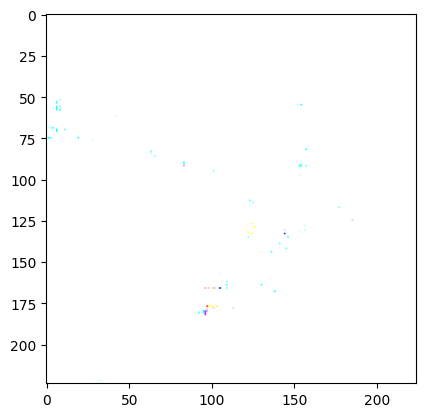

1/1 [==============================] - 0s 20ms/step


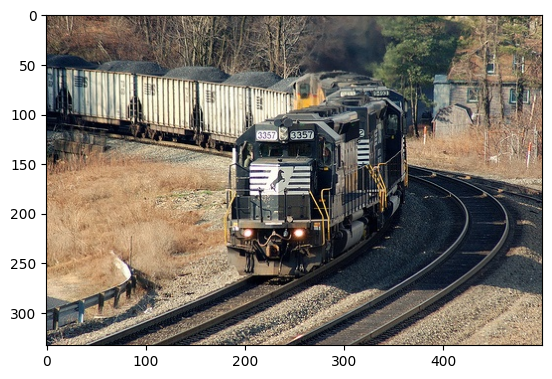

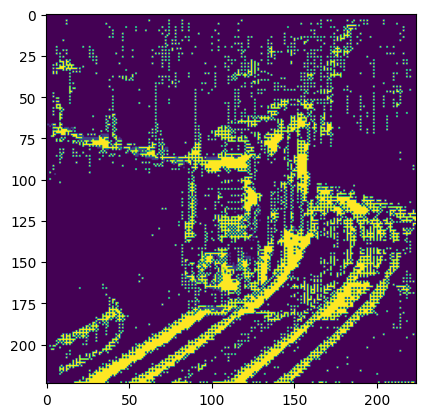

In [187]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def create_segmentation_map(model,preproc , image, input_size=(224, 224)):
    """
    모델과 이미지를 받아서 세그멘테이션 맵을 생성하는 함수.

    :param model: 학습된 모델.
    :param image: 세그멘테이션을 수행할 이미지.
    :param input_size: 모델에 입력하기 전에 이미지를 조정할 크기.
    :return: 세그멘테이션 맵.
    """
    
    # 이미지 전처리
    resized_image = tf.image.resize(image, input_size)
    resized_image = resized_image 
    print(resized_image[0][0])
    plt.imshow(resized_image)
    plt.show()
    input_image = np.expand_dims(resized_image, axis=0)  # 배치 차원 추가

    # 모델을 통해 세그멘테이션 예측 수행
    prediction = model.predict(input_image)

    # 예측 결과를 이미지로 변환
    predicted_image = np.argmax(prediction, axis=-1) 
    predicted_image = predicted_image[0, :, :]  # 첫 번째 이미지 선택 및 배치 차원 제거

    return predicted_image

# 사용 예시
# model = ... # 학습된 모델을 로드합니다.
# image = ... # 세그멘테이션을 수행할 이미지를 로드합니다.
segmentation_map = create_segmentation_map(unet,augmentation_test, np.array(dataset[10]["image"]) )
plt.imshow(dataset[10]["image"])
plt.show()
# 세그멘테이션 맵 시각화
plt.imshow(segmentation_map)
plt.show()

In [189]:
inverse_mapping

{0: (0, 0, 0),
 1: (128, 0, 0),
 2: (192, 128, 128),
 3: (224, 224, 192),
 4: (0, 64, 128),
 5: (64, 0, 128),
 6: (192, 0, 0),
 7: (128, 128, 0),
 8: (128, 0, 128),
 9: (0, 0, 128),
 10: (192, 128, 0),
 11: (128, 192, 0),
 12: (64, 128, 128),
 13: (192, 0, 128),
 14: (64, 128, 0),
 15: (0, 128, 0),
 16: (128, 128, 128),
 17: (64, 0, 0),
 18: (0, 192, 0),
 19: (0, 128, 128),
 20: (0, 64, 0),
 21: (128, 64, 0)}

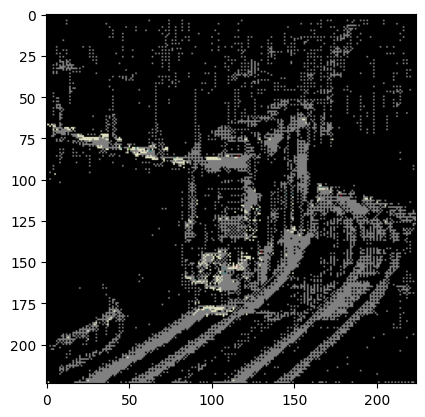

[ 0  1  2  3 12 14 16]


In [197]:

restored_color_mask = map_integer_mask_to_color(segmentation_map, inverse_mapping)
plt.imshow(restored_color_mask)
plt.show()
restored_color_mask.shape
unique_values, counts = np.unique(segmentation_map, return_counts=True)

print(unique_values)